NOTE: This notebook uses a JSON dictionary created by the `ndlar_flow/scripts/low_level_data_ana/charge_data_feature_studies/adc_saturation/ADC_Saturation_Sample.py` script. As this notebook comprises of preliminary/diagnostic studies, the code may not be fully optimized. The code will be optimized in terms of runtime and organization as time permits. Please contact Elise Hinkle (ehinkle@uchicago.edu) with any questions, comments, or concerns. Also, all JSON dictionary file locations are likely outdated and should be changed based on where the user has chosen to store the relevant dictionary(ies).

In [2]:
# Import relevant packages/libraries
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import h5py
import argparse
from datetime import datetime
import glob
import json
import cmasher as cmr
import math
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec
import sys
import os
import sys
sys.path.append('/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_sim/run-ndlar-flow/ndlar_flow/event_display/LAr_evd/')
from lar2x2_evd import *
from collections import Counter

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Hello


In [2]:
# Open dictionary with ADC Saturation BEAM events (removing noisy channels identified using adc_saturation_event_initial_exploration.ipynb)
adc_sat_file = '/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_sim/run-ndlar-flow/ndlar_flow/event_display/LAr_evd/adc_saturation_beam_events_V5_FINAL_REMOVAL_dict.json'
adc_sat_open = open(adc_sat_file)
adc_sat_dict = json.load(adc_sat_open)

15639
15639
16181
[41 60 12 38 37 38 12 32 34 59 37 52 59 17 11 61 47  7  7 43]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
16181
16181
10504
5677


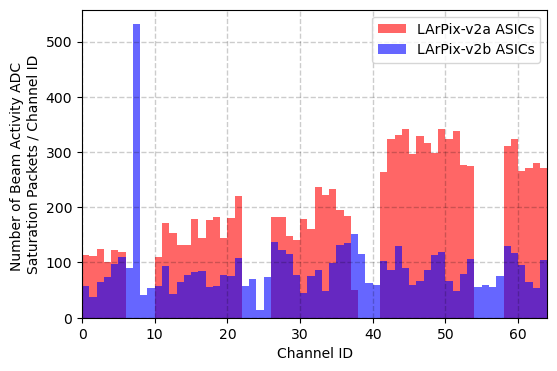

In [3]:
# This cell is used to look at the distribution of channel IDs on which ADC saturation packets are received for LArPix-v2a and LArPix-v2b ASICs in 2x2


# Make arrays of unique channels (channel id, iogroup are main IDs of interest) with ADC saturation packets, the number of ADC  
# saturation packets per unique channel, and energy deposited in the iogroup associated with the channel receiving the ADC saturation packet
unique_channels_with_adc_sat_packets = [adc_sat_dict[k]['unique_channels_impacted'] for k in adc_sat_dict.keys()]
unique_channels_counts = [adc_sat_dict[k]['total_sat_packets_per_unique_channel'] for k in adc_sat_dict.keys()]
unique_channel_ids_with_adc_sat_packets = np.array([item[3] for sublist in unique_channels_with_adc_sat_packets for item in sublist])
unique_iog_with_adc_sat_packets = np.array([item[0] for sublist in unique_channels_with_adc_sat_packets for item in sublist])
channel_counts_with_adc_sat_packets = np.array([item for sublist in unique_channels_counts for item in sublist])
iog_negative_energy = [[adc_sat_dict[k]['iog_negative_energy']]*adc_sat_dict[k]['num_adc_saturation_packets'] for k in adc_sat_dict.keys()]
iog_positive_energy = [[adc_sat_dict[k]['iog_positive_energy']]*adc_sat_dict[k]['num_adc_saturation_packets'] for k in adc_sat_dict.keys()]
single_adc_sat_packet_iog_pos_energy = np.array([item for sublist in iog_positive_energy for item in sublist])
single_adc_sat_packet_iog_neg_energy = np.array([item for sublist in iog_negative_energy for item in sublist])
print(len(unique_channel_ids_with_adc_sat_packets))
print(len(channel_counts_with_adc_sat_packets))
print(len(single_adc_sat_packet_iog_pos_energy))
print(unique_channel_ids_with_adc_sat_packets[:20])
print(channel_counts_with_adc_sat_packets[:20])
print(sum(channel_counts_with_adc_sat_packets))
channel_ids_all = []
channel_ids_v2a = []
channel_ids_v2b = []
iog_pos_energy = []
iog_neg_energy = []

# Separate LArPix-v2a and LArPix-v2b ASICs (for 2x2, iogroups 1,2,3,4,7,8 are v2a and iogroups 5,6 are v2b)
for i in range(len(unique_channel_ids_with_adc_sat_packets)):
    iog = unique_iog_with_adc_sat_packets[i]
    if channel_counts_with_adc_sat_packets[i] == 1:
        channel_ids_all.append(unique_channel_ids_with_adc_sat_packets[i])
        iog_pos_energy.append(single_adc_sat_packet_iog_pos_energy[i][iog-1])
        iog_neg_energy.append(single_adc_sat_packet_iog_neg_energy[i][iog-1])
        if iog == 5 or iog == 6:
            channel_ids_v2b.append(unique_channel_ids_with_adc_sat_packets[i])
        else:
            channel_ids_v2a.append(unique_channel_ids_with_adc_sat_packets[i])
    else:
        channel_ids_all.extend([unique_channel_ids_with_adc_sat_packets[i]]*channel_counts_with_adc_sat_packets[i])
        iog_pos_energy.extend([single_adc_sat_packet_iog_pos_energy[i][iog-1]]*channel_counts_with_adc_sat_packets[i])
        iog_neg_energy.extend([single_adc_sat_packet_iog_neg_energy[i][iog-1]]*channel_counts_with_adc_sat_packets[i])
        if iog == 5 or iog == 6:
            channel_ids_v2b.extend([unique_channel_ids_with_adc_sat_packets[i]]*channel_counts_with_adc_sat_packets[i])
        else:
            channel_ids_v2a.extend([unique_channel_ids_with_adc_sat_packets[i]]*channel_counts_with_adc_sat_packets[i])

print(len(channel_ids_all))
print(len(channel_ids_v2a))
print(len(channel_ids_v2b))

# Plot histogram of number of ADC saturation packets per channel ID for LArPix-v2a and LArPix-v2b ASICs
fig, ax = plt.subplots(1,1,figsize=(6,4))
#ax.hist(channel_ids_all, bins=np.linspace(0,64, 65), histtype='stepfilled', linewidth=2, color='b', alpha=0.5, label = 'All LArPix ASICs')
ax.hist(channel_ids_v2a, bins=np.linspace(0,64, 65), histtype='stepfilled', linewidth=2, color='r', alpha=0.6, label = 'LArPix-v2a ASICs')
ax.hist(channel_ids_v2b, bins=np.linspace(0,64, 65), histtype='stepfilled', linewidth=2, color='b', alpha=0.6, label = 'LArPix-v2b ASICs')
ax.set_xlabel('Channel ID')
ax.set_ylabel('Number of Beam Activity ADC \nSaturation Packets / Channel ID')
ax.set_xlim(0,64)
ax.grid(True, which='both', linestyle='--', linewidth=1, alpha=0.2, color='k')
ax.legend(loc='upper right')

Text(0.5, 0.98, 'Energy Distributions for Beam Events with Beam Activity ADC Saturation Packets')

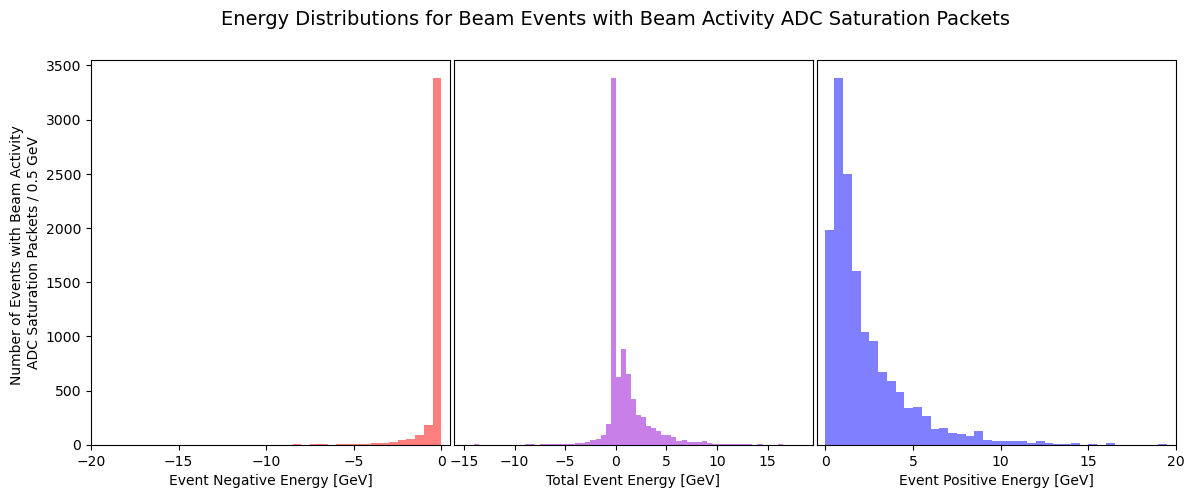

In [4]:
# Histograms showing full event energy (recorded as positive, recorded as negative, and total positive+negative) for events with beam activity ADC saturation packets

event_pos_energy_for_adc_sat_packets = [adc_sat_dict[k]['total_positive_energy'] for k in adc_sat_dict.keys()]
event_neg_energy_for_adc_sat_packets = [adc_sat_dict[k]['total_negative_energy'] for k in adc_sat_dict.keys()]
event_total_energy_for_adc_sat_packets = event_pos_energy_for_adc_sat_packets + event_neg_energy_for_adc_sat_packets
fig, axs = plt.subplots(1,3, figsize=(14, 5))

axs[1].hist(np.array(event_total_energy_for_adc_sat_packets)/1000, bins=np.linspace(-16,20,73),histtype='stepfilled', color='darkviolet', alpha=0.5)
axs[1].set_xlabel('Total Event Energy [GeV]')
#axs[1].sharey(axs[0])
#axs[1].set_ylabel('Number of Tiles Exhibiting Whole-Tile Triggering')
axs[1].set_yticks([])
axs[1].set_yticklabels([])
#axs[1].set_ylim(0, 40)
axs[1].set_xlim(-16, 19.5)

axs[2].hist(np.array(event_pos_energy_for_adc_sat_packets)/1000, bins=np.linspace(0,20,41), histtype='stepfilled', color='b', alpha=0.5)
axs[2].set_xlabel('Event Positive Energy [GeV]')
#axs[2].set_ylabel('Number of Tiles Exhibiting Whole-Tile Triggering')
axs[2].set_yticks([])
axs[2].set_yticklabels([])
#axs[2].set_ylim(0, 40)
axs[2].set_xlim(-0.5, 20)

axs[0].hist(np.array(event_neg_energy_for_adc_sat_packets)/1000, bins=np.linspace(-20,0,41), histtype='stepfilled', color='r', alpha=0.5)
axs[0].set_xlabel('Event Negative Energy [GeV]')
axs[0].set_ylabel('Number of Events with Beam Activity \nADC Saturation Packets / 0.5 GeV')
#axs[0].set_ylim(0, 20)
axs[0].set_xlim(-20, 0.5)
plt.subplots_adjust(wspace=0.01)
#axs[0].set_yticklabels([])
fig.suptitle('Energy Distributions for Beam Events with Beam Activity ADC Saturation Packets', fontsize=14)


Text(0.5, 0.98, 'Energy Distribution in TPCs Recording Beam Activity ADC Saturation Packet')

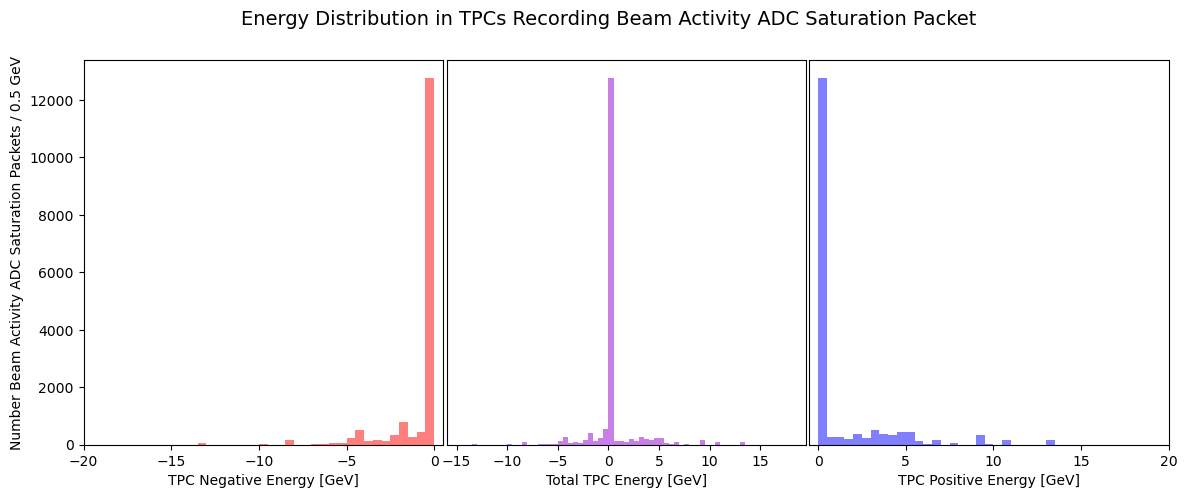

In [5]:
# Histograms showing energy (recorded as positive, recorded as negative, and total positive+negative) recorded by the iogroup 
# associated with a beam activity ADC saturation packet for events with beam activity ADC saturation packets

iog_total_energy = iog_pos_energy + iog_neg_energy
fig, axs = plt.subplots(1,3, figsize=(14, 5))

axs[1].hist(np.array(iog_total_energy)/1000, bins=np.linspace(-16,20,73),histtype='stepfilled', color='darkviolet', alpha=0.5)
axs[1].set_xlabel('Total TPC Energy [GeV]')
#axs[1].sharey(axs[0])
#axs[1].set_ylabel('Number of Tiles Exhibiting Whole-Tile Triggering')
axs[1].set_yticks([])
axs[1].set_yticklabels([])
#axs[1].set_ylim(0, 40)
axs[1].set_xlim(-16, 19.5)

axs[2].hist(np.array(iog_pos_energy)/1000, bins=np.linspace(0,20,41), histtype='stepfilled', color='b', alpha=0.5)
axs[2].set_xlabel('TPC Positive Energy [GeV]')
#axs[2].set_ylabel('Number of Tiles Exhibiting Whole-Tile Triggering')
axs[2].set_yticks([])
axs[2].set_yticklabels([])
#axs[2].set_ylim(0, 40)
axs[2].set_xlim(-0.5, 20)

axs[0].hist(np.array(iog_neg_energy)/1000, bins=np.linspace(-20,0,41), histtype='stepfilled', color='r', alpha=0.5)
axs[0].set_xlabel('TPC Negative Energy [GeV]')
axs[0].set_ylabel('Number Beam Activity ADC Saturation Packets / 0.5 GeV')
#axs[0].set_ylim(0, 20)
axs[0].set_xlim(-20, 0.5)
plt.subplots_adjust(wspace=0.01)
#axs[0].set_yticklabels([])
fig.suptitle('Energy Distribution in TPCs Recording Beam Activity ADC Saturation Packet', fontsize=14)

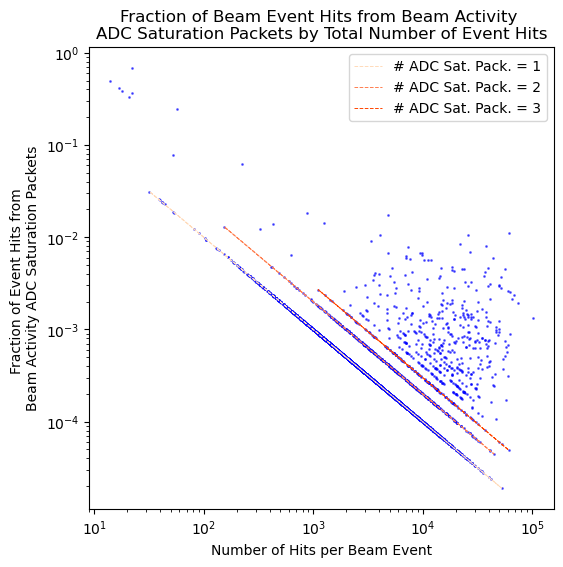

In [10]:
# Collect information and make plot showing the fraction of event hits from beam activity ADC saturation packets by total number of event hits
# This includes a linear regression on a log-log plot of fraction of event hits from beam activity ADC saturation packets by total number of event hits
# where the linear regression is done separately for events with 1, 2, and 3 ADC saturation packets. This is done to elucidate some of the 
# substructure apparent in this scatterplot.
# This section includes plots commented out from adc_saturation_event_initial_exploration.ipynb

nhits_per_event = [adc_sat_dict[k]['nhits'] for k in adc_sat_dict.keys()]
n_adc_sat_per_event = [adc_sat_dict[k]['num_adc_saturation_packets'] for k in adc_sat_dict.keys()]
frac_hits_adc_sat = [adc_sat_dict[k]['num_adc_saturation_packets']/adc_sat_dict[k]['nhits'] for k in adc_sat_dict.keys()]

unique_channels_with_adc_sat_packets = [adc_sat_dict[k]['unique_channels_impacted'] for k in adc_sat_dict.keys()]
unique_channels_per_event = unique_channels_with_adc_sat_packets
iog_with_adc_sat_packets = [set([channel[0] for channel in unique_channels_per_event[i]]) for i in range(len(unique_channels_per_event))]
iog_with_adc_sat_packets_counts_per_event = Counter(map(tuple, iog_with_adc_sat_packets))


#fig, axs = plt.subplots(2,1, figsize=(5,12))
fig, axs = plt.subplots(1,1, figsize=(6,6))
max_nhits = math.ceil(max(nhits_per_event)/100)*100
min_nhits = math.floor(min(nhits_per_event)/100)*100

max_adc_sat_packets = math.ceil(max(n_adc_sat_per_event)/10)*10
min_adc_sat_packets = math.floor(min(n_adc_sat_per_event)/10)*10

axs.scatter(nhits_per_event, frac_hits_adc_sat, color='b', marker='o', s=1, alpha=0.55)
#axs[0].hist(nhits_per_event, bins=int((max_nhits-min_nhits)/1000), range=(min_nhits, max_nhits), color='b', alpha=0.5)
axs.set_yscale('log')
axs.set_xscale('log')
# Fit a linear regression line
subset_nhits1 = np.where(np.array(n_adc_sat_per_event) == 1)
m1, b1 = np.polyfit(np.log(np.array(nhits_per_event)[subset_nhits1]), np.log(np.array(frac_hits_adc_sat)[subset_nhits1]), 1)
axs.plot(np.array(np.array(nhits_per_event)[subset_nhits1]), np.exp(m1*np.log(np.array(nhits_per_event)[subset_nhits1]) + b1), \
            color='peachpuff', linestyle='--', linewidth=0.7, label="# ADC Sat. Pack. = 1")
subset_nhits2 = np.where(np.array(n_adc_sat_per_event) == 2)
m2, b2 = np.polyfit(np.log(np.array(nhits_per_event)[subset_nhits2]), np.log(np.array(frac_hits_adc_sat)[subset_nhits2]), 1)
axs.plot(np.array(np.array(nhits_per_event)[subset_nhits2]), np.exp(m2*np.log(np.array(nhits_per_event)[subset_nhits2]) + b2), \
            color='coral', linestyle='--', linewidth=0.7, label="# ADC Sat. Pack. = 2")
subset_nhits3 = np.where(np.array(n_adc_sat_per_event) == 3)
m3, b3 = np.polyfit(np.log(np.array(nhits_per_event)[subset_nhits3]), np.log(np.array(frac_hits_adc_sat)[subset_nhits3]), 1)
axs.plot(np.array(np.array(nhits_per_event)[subset_nhits3]), np.exp(m3*np.log(np.array(nhits_per_event)[subset_nhits3]) + b3), \
            color='orangered', linestyle='--', linewidth=0.7, label="# ADC Sat. Pack. = 3")

axs.set_title('Fraction of Beam Event Hits from Beam Activity \nADC Saturation Packets by Total Number of Event Hits')
axs.set_xlabel('Number of Hits per Beam Event')
axs.set_ylabel('Fraction of Event Hits from \nBeam Activity ADC Saturation Packets')
axs.legend()
#axs[0].set_ylabel('Beam Event Count / 1000 Hits')
#
#axs[1].hist(n_adc_sat_per_event, bins=int((max_adc_sat_packets-min_adc_sat_packets)/10), range=(min_adc_sat_packets, max_adc_sat_packets), color='b', alpha=0.5)
#axs[1].set_yscale('log')
#axs[1].set_title('Beam Activity ADC Saturation Packets per Beam Event')
#axs[1].set_xlabel('Number of Beam Activity ADC Saturation Packets')
#axs[1].set_ylabel('Beam Event Count / 10 Packets')

#other_size = 0
#labels= ['', '', '', '', '', '', '', '', '']
#sizes = np.zeros(9)
#for key, value in iog_with_adc_sat_packets_counts_per_event.items():
#    if len(key) > 1:
#        other_size += value
#    elif len(key) == 1:
#        labels[9-key[0]]=str(key[0])
#        sizes[9-key[0]]=value
#    else:
#        continue
#if other_size > 0:
#    labels[0] = 'Multiple'
#    sizes[0] =other_size
#print(labels)
#print(sizes)
#colors = ['darkgray', 'mediumorchid', 'violet', 'orange', 'gold',\
#          'cornflowerblue', 'deepskyblue','mediumseagreen', 'lime']
#axs[1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
#axs[1].axis('equal')
#axs[1].set_title('Beam-Related ADC Saturation Packets IO Groups by Event')

First timestamp: 2024-07-10 09:08:23
308
Key of first file: /global/cfs/cdirs/dune/www/data/2x2/nearline/flowed_charge/REFLOW/v1/beam/july8_2024/nominal_hv/packet-0050017-2024_07_10_04_07_32_CDT.FLOW.hdf5-353


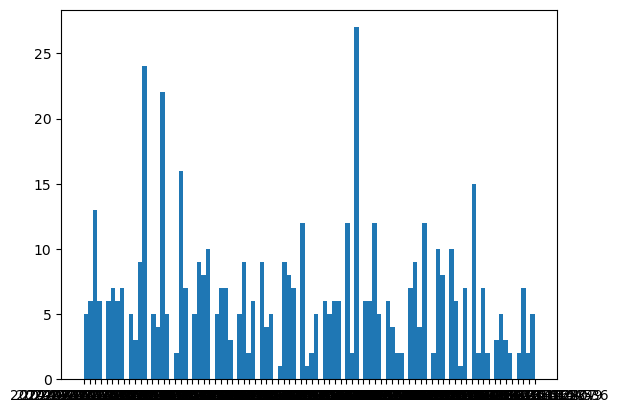

In [27]:
# This cell was exploration towards understanding the behavior of certain "noisy" chips sending ADC saturation packets in at least 5 events. 
# This work is continued in investigate_noisy_adc_saturated_chips_over_time.ipynb
# Open dictionary with ADC Saturation BEAM events
adc_sat_file = '/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_sim/run-ndlar-flow/ndlar_flow/event_display/LAr_evd/adc_saturation_beam_events_dict.json'
adc_sat_open = open(adc_sat_file)
adc_sat_dict = json.load(adc_sat_open)

timestamps = []
file_keys = []
for k in adc_sat_dict.keys():
    if adc_sat_dict[k]['num_adc_saturation_packets'] == 1:
        continue
    else:
        for channel in adc_sat_dict[k]['unique_channels_impacted']:
            if channel[0] == 2 and channel[1] == 29 and channel[2] == 31:
                timestamp = adc_sat_dict[k]['timestamp']
                timestamps.append(adc_sat_dict[k]['timestamp'])
                file_keys.append(k)
                continue
            else:
                continue

plt.hist(timestamps, bins=100)
print("First timestamp:", min(timestamps))
idx_min_tstamp = np.argmin(np.array(timestamps))
print(idx_min_tstamp)
print("Key of first file:", file_keys[idx_min_tstamp])